In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
customers = pd.read_csv(r"C:\Users\rabia\Project_workintech\Workintech_data_analysis_graduation_project\data\customers.csv")
orders = pd.read_csv(r"C:\Users\rabia\Project_workintech\Workintech_data_analysis_graduation_project\data\orders_updated.csv")
products = pd.read_csv(r"C:\Users\rabia\Project_workintech\Workintech_data_analysis_graduation_project\data\products.csv")
sales = pd.read_csv(r"C:\Users\rabia\Project_workintech\Workintech_data_analysis_graduation_project\data\sales.csv")
product_performance = pd.read_csv(r"C:\Users\rabia\Project_workintech\Workintech_data_analysis_graduation_project\data\product_performance.csv")

In [3]:
df = sales.merge(products, left_on='product_id', right_on='product_ID', how='left')
df = df.rename(columns={'quantity_x':'quantity_sold'})
df = df.rename(columns={'quantity_y':'quantity_product'})


# Logistic Regression: Product Segment Classification

Model: Logistic Regression (Segment Prediction)

Amaç: Ürünün satış ve kârlılık metriklerine göre hangi performans segmentine ait olduğunu otomatik tahmin etmek

In [4]:
# feature set 
features = ['unit_profitability', 'PPI_scaled']
X = product_performance[features]
y = product_performance['segment']

In [5]:
# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [6]:
# Ölçekleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

In [8]:
#  MODEL EĞİTİMİ
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [9]:
# TAHMİN VE DEĞERLENDİRME
y_pred = model.predict(X_test)

In [10]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:

                         precision    recall  f1-score   support

        High Performers       1.00      0.89      0.94        75
Premium / Niche Segment       0.87      1.00      0.93        55
        Underperformers       1.00      1.00      1.00        62
        Volume Products       1.00      1.00      1.00        55

               accuracy                           0.97       247
              macro avg       0.97      0.97      0.97       247
           weighted avg       0.97      0.97      0.97       247



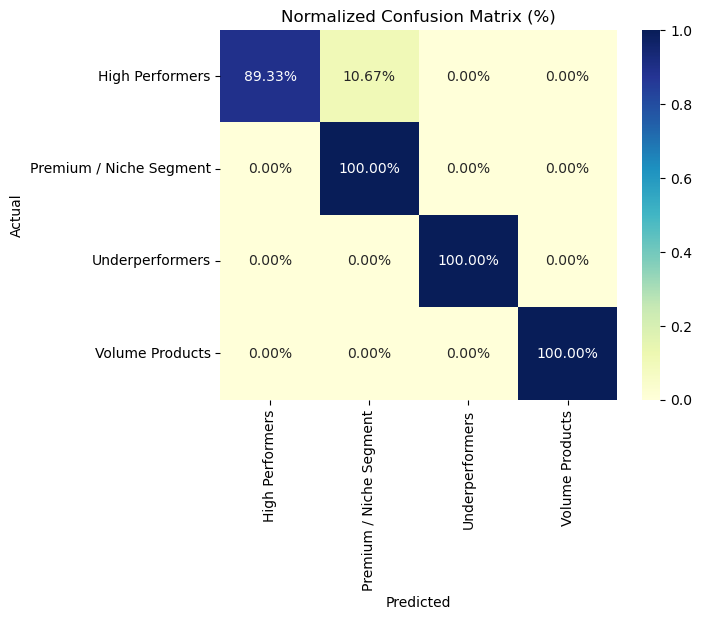

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm / cm.sum(axis=1)[:, None],
            annot=True, fmt='.2%', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
# FEATURE IMPORTANCE
coeff = pd.DataFrame(model.coef_, columns=features, index=le.classes_)
print("\nFeature Coefficients (impact on segment probability):")
print(coeff)


Feature Coefficients (impact on segment probability):
                         unit_profitability  PPI_scaled
High Performers                    3.812814    5.076893
Premium / Niche Segment            4.054276   -6.090791
Underperformers                   -3.753603   -5.474682
Volume Products                   -4.113488    6.488580


In [13]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_scaled, y_encoded, cv=5)
print("\nCross-Validation Scores:")
print(scores)


Cross-Validation Scores:
[0.61133603 1.         1.         1.         0.73170732]


# Random Forest: Product Segment Classification

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [15]:
#CUSTOMER FEATURES 

orders_customers = orders.merge(customers, on='customer_id', how='left')
sales_orders = sales.merge(orders_customers, on='order_id', how='left')

customer_features = (
    sales_orders.groupby('product_id')
    .agg(
        avg_customer_age=('age', 'mean'),
        gender_ratio=('gender', lambda x: (x=='Female').mean()),
        region_popularity=('city', lambda x: x.nunique()),
        repeat_purchase_rate=('customer_id', lambda x: x.value_counts().gt(1).sum() / len(x)),
        avg_order_value=('total_price', 'mean')
    )
    .reset_index()
)

In [69]:
df = product_performance.copy()

df = df.merge(
    products[['product_ID', 'size', 'colour', 'quantity']],
    left_on='product_id', right_on='product_ID', how='left'
)

df['description_length'] = df['description'].astype(str).apply(len)

df = df.merge(customer_features, on='product_id', how='left')

df = df.fillna({
    'avg_customer_age': df['avg_customer_age'].mean(),
    'gender_ratio': 0.5,
    'region_popularity': 1,
    'repeat_purchase_rate': 0,
    'avg_order_value': df['total_revenue'] / df['total_sold']
})

cat_features = ['product_type', 'size', 'colour']
num_features = [
    'quantity', 'description_length',
    'avg_customer_age', 'gender_ratio', 'region_popularity',
    'repeat_purchase_rate', 'avg_order_value','unit_profitability'
]

In [70]:
# hedef değişken
y = df['segment']
X = df[cat_features + num_features]

In [71]:
# Encoding ve scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

In [72]:
# Veri bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Pipeline ile model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=8))
])

In [74]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [75]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

                         precision    recall  f1-score   support

        High Performers       0.89      0.86      0.88        87
Premium / Niche Segment       0.77      0.82      0.79        49
        Underperformers       0.95      0.95      0.95        60
        Volume Products       0.94      0.94      0.94        51

               accuracy                           0.89       247
              macro avg       0.89      0.89      0.89       247
           weighted avg       0.89      0.89      0.89       247



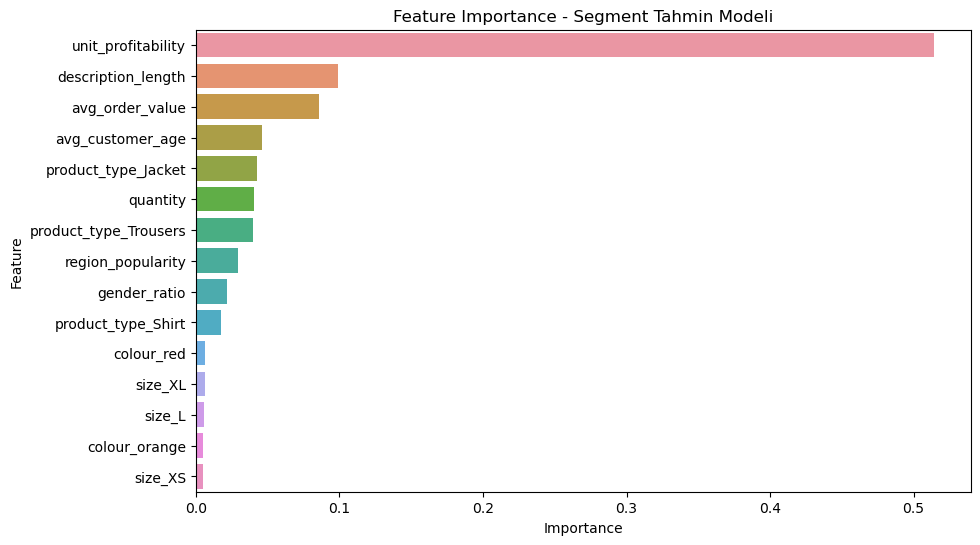

In [76]:
# Feature importance
importances = model.named_steps['classifier'].feature_importances_
feature_names = (num_features +
                 list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)))

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=fi_df, x='Importance', y='Feature')
plt.title("Feature Importance - Segment Tahmin Modeli")
plt.show()


In [77]:
# Confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=model.classes_, normalize='true')

labels = model.classes_

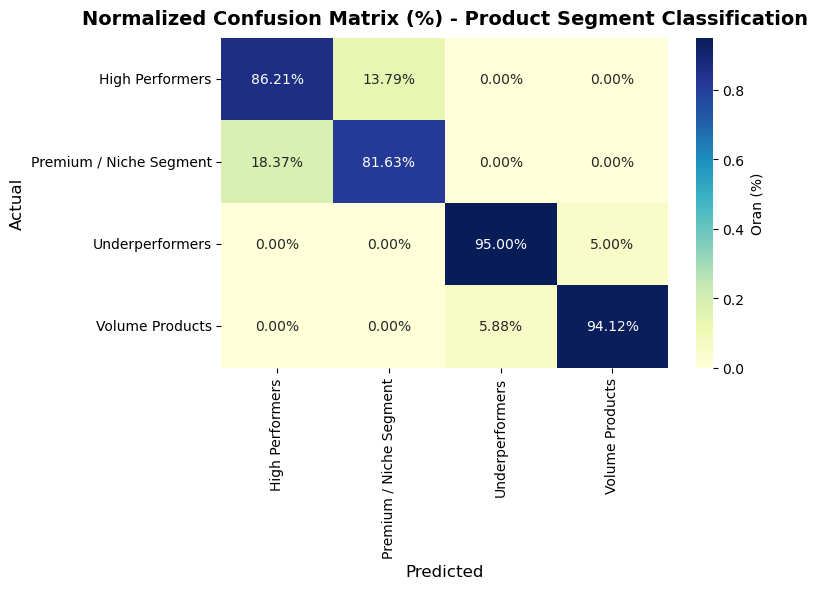

In [78]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="YlGnBu",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Oran (%)'})

plt.title("Normalized Confusion Matrix (%) - Product Segment Classification",
          fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.tight_layout()
plt.show()

# K-Means Product Clustering

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [25]:
# 🔹 Kümelenecek sayısal özelliklerç
cluster_features = [
    'unit_profitability', 'total_sold', 'total_revenue',
    'avg_customer_age', 'gender_ratio', 'region_popularity',
    'repeat_purchase_rate', 'avg_order_value'
]

# 🔹 Sadece gerekli kolonlar
X = df[cluster_features].fillna(0)

# 🔹 Ölçekleme (K-Means için önemli)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\rabia\.anaconda\ie358\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabia\.anaconda\ie358\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabia\.anaconda\ie358\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabia\.anaconda\ie358\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

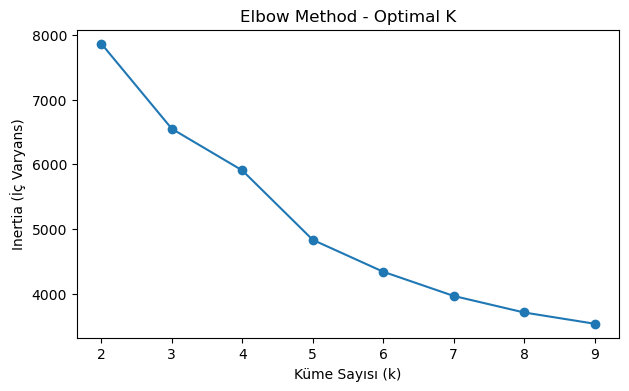

In [26]:
#En uygun küme sayısı (Elbow Method)
inertia = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia (İç Varyans)')
plt.title('Elbow Method - Optimal K')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Küme merkezleri
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_features
)

cluster_centers['cluster'] = range(1, len(cluster_centers)+1)
print(cluster_centers)

C:\Users\rabia\.anaconda\ie358\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   unit_profitability  total_sold  total_revenue  avg_customer_age  \
0           97.916221  277.012478   27080.347594         47.369050   
1          113.451372  280.822943   31905.431421         49.921078   
2          100.730392  272.279412   27390.156863         49.401801   
3           99.428843  527.000000   52399.000000         50.208120   

   gender_ratio  region_popularity  repeat_purchase_rate  avg_order_value  \
0      0.053813           4.099822          2.970885e-04       183.553337   
1      0.096426           4.286783          3.376479e-03       242.121793   
2      0.489522           3.387255          8.533868e-03       197.173825   
3      0.147868           4.074627         -2.168404e-18       190.096624   

   cluster  
0        1  
1        2  
2        3  
3        4  


In [28]:
display(cluster_centers.style.background_gradient(cmap="YlGnBu"))

,unit_profitability,total_sold,total_revenue,avg_customer_age,gender_ratio,region_popularity,repeat_purchase_rate,avg_order_value,cluster
0,97.916221,277.012478,27080.347594,47.369050,0.053813,4.099822,0.000297,183.553337,1
1,113.451372,280.822943,31905.431421,49.921078,0.096426,4.286783,0.003376,242.121793,2
2,100.730392,272.279412,27390.156863,49.401801,0.489522,3.387255,0.008534,197.173825,3
3,99.428843,527.000000,52399.000000,50.208120,0.147868,4.074627,-0.000000,190.096624,4


| Cluster | Özellik Profili                                        | Doğru Segment İsmi               | Açıklama                                      |
| ------- | ------------------------------------------------------ | -------------------------------- | --------------------------------------------- |
| **0**   | her metrikte yüksek (profit 4, AOV 4, her şey 3–4)     | **Premium / High-Value Segment** | yüksek kâr, yüksek sepet, dengeli satış hacmi |
| **1**   | düşük değerler (profit 3, sold 1, age 1, pop 1, AOV 1) | **Value / Entry-Level Products** | genç kitle, fiyat odaklı, dar pazar           |
| **2**   | satış ve gelir en yüksek (sold 4, revenue 4)           | **Top Sellers / Volume Drivers** | ciro motoru, düşük marj, yüksek satış         |
| **3**   | profit en düşük (1), satış orta, yaş en yüksek (4)     | **Mature / Declining Segment**   | yaşlı müşteri, doygun pazar, düşük performans |


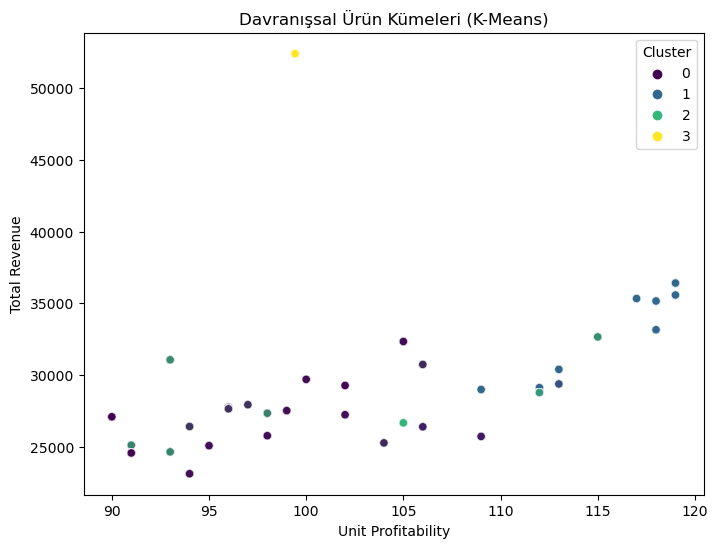

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x='unit_profitability', y='total_revenue',
    hue='cluster', palette='viridis', alpha=0.7
)
plt.title('Davranışsal Ürün Kümeleri (K-Means)')
plt.xlabel('Unit Profitability')
plt.ylabel('Total Revenue')
plt.legend(title='Cluster')
plt.show()

# Co-occurrence / Product Affinity Analysis

In [31]:
from itertools import combinations
from collections import Counter

In [33]:
products_for_affinity = sales.merge(products, left_on='product_id', right_on='product_ID', how='left')

order_products = (
    products_for_affinity.groupby('order_id')
      .apply(lambda x: list((x['product_name'] + " (" + x['product_type'] + ")").unique()))
)

pairs = []
for prods in order_products:
    pairs += list(combinations(sorted(prods), 2))

pair_counts = Counter(pairs)

cooc_df = (
    pd.DataFrame(pair_counts.items(), columns=['Product Pair', 'Count'])
      .sort_values(by='Count', ascending=False)
      .reset_index(drop=True)
)

product_map = products.set_index('product_ID')['product_name'].to_dict()

cooc_df['Product 1'] = cooc_df['Product Pair'].apply(lambda x: product_map.get(x[0], x[0]))
cooc_df['Product 2'] = cooc_df['Product Pair'].apply(lambda x: product_map.get(x[1], x[1]))
cooc_df = cooc_df[['Product 1','Product 2','Count']]
cooc_df.head(5)

,Product 1,Product 2,Count
0,Camp Collared (Shirt),Slim-Fit (Trousers),29
1,Casual Slim Fit (Shirt),Windbreaker (Jacket),29
2,Bomber (Jacket),Linen (Shirt),28
3,Flannel (Shirt),Shearling (Jacket),27
4,Cargo Pants (Trousers),Joggers (Trousers),27


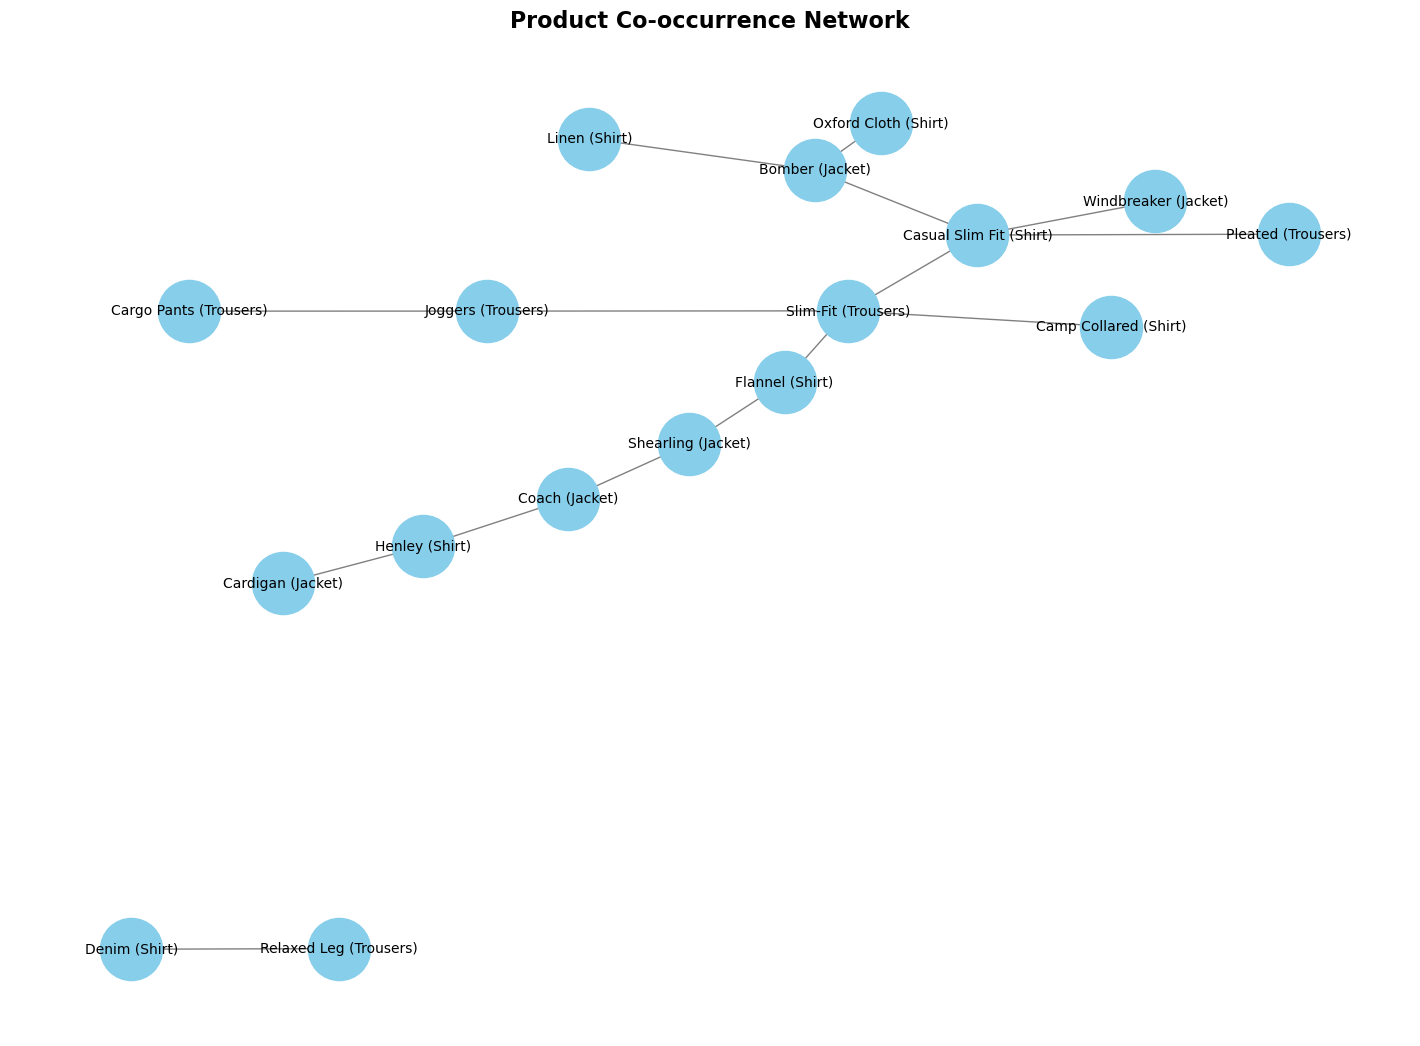

In [58]:
import networkx as nx

top_pairs = cooc_df.head(15)

G = nx.Graph()
for _, row in top_pairs.iterrows():
    G.add_edge(row['Product 1'], row['Product 2'], weight=row['Count'])

plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.4, iterations=50)
edges = G.edges(data=True)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10,
        node_color='skyblue', edge_color='gray')
plt.title("Product Co-occurrence Network", fontsize=16, fontweight='bold')
plt.show()

In [55]:
def recommend_products(product_name, top_n=5):
    product_name = product_name.lower()
    related = cooc_df[
        (cooc_df['Product 1'].str.lower() == product_name) |
        (cooc_df['Product 2'].str.lower() == product_name)
    ]
    if related.empty:
        related = cooc_df[
            cooc_df['Product 1'].str.contains(product_name, case=False) |
            cooc_df['Product 2'].str.contains(product_name, case=False)
        ]
    related = related.sort_values(by='Count', ascending=False).head(top_n)
    recommendations = []
    for _, row in related.iterrows():
        recommendations.append(row['Product 2'] if row['Product 1'].lower() == product_name else row['Product 1'])
    return recommendations

# örnek:
recommend_products("Slim-Fit (trousers)")

['Camp Collared (Shirt)',
 'Casual Slim Fit (Shirt)',
 'Joggers (Trousers)',
 'Flannel (Shirt)',
 'Linen (Shirt)']

In [38]:
top_recs = []

all_products = pd.unique(cooc_df[['Product 1', 'Product 2']].values.ravel('K'))

for prod in all_products:
    recs = recommend_products(prod, top_n=3)  
    top_recs.append({
        'Product': prod,
        'Recommendation 1': recs[0] if len(recs) > 0 else None,
        'Recommendation 2': recs[1] if len(recs) > 1 else None,
        'Recommendation 3': recs[2] if len(recs) > 2 else None
    })

recommendation_table = pd.DataFrame(top_recs)
recommendation_table.head()

,Product,Recommendation 1,Recommendation 2,Recommendation 3
0,Camp Collared (Shirt),Slim-Fit (Trousers),Cords (Trousers),Denim (Shirt)
1,Casual Slim Fit (Shirt),Windbreaker (Jacket),Slim-Fit (Trousers),Pleated (Trousers)
2,Bomber (Jacket),Linen (Shirt),Oxford Cloth (Shirt),Casual Slim Fit (Shirt)
3,Flannel (Shirt),Shearling (Jacket),Slim-Fit (Trousers),Denim (Shirt)
4,Cargo Pants (Trousers),Joggers (Trousers),Chinos (Trousers),Casual Slim Fit (Shirt)


In [60]:
# export csv
#recommendation_table.to_csv(r"C:\Users\rabia\Project_workintech\Workintech_data_analysis_graduation_project\data\product_recommendation.csv",index=False, encoding='utf-8-sig')